In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [4]:
score = pd.read_csv('../LBLS467-data/score.csv')
srl_motivation = pd.read_csv('../LBLS467-data/srl_motivation.csv')
sill = pd.read_csv('../LBLS467-data/sill.csv')
srl_strategy = pd.read_csv('../LBLS467-data/srl_strategy.csv')
br = pd.read_csv('../LBLS467-data/br.csv')
viscode = pd.read_csv('../LBLS467-data/viscode.csv')

In [5]:
from functools import reduce

dfs = [score, srl_motivation, sill, srl_strategy, br]

def merge_keep_left(left, right):
    right = right[[col for col in right.columns if col not in left.columns or col == "userid"]]
    return pd.merge(left, right, on="userid", how="inner")

merged = reduce(merge_keep_left, dfs)


In [6]:
X = merged.drop(["userid","class","score",'Unnamed: 0'], axis=1)  
y = merged["score"]

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def single_nudging_iteration(X, y, n_rounds=5, n_splits=5, plot_each_round=False, w=5):
    """
    Run iterative nudging simulation based on Ambiguity Aversion using MANUAL CV LOOP.
    
    Why Manual CV? 
    Standard `cross_val_predict` discards the individual trees, making it impossible 
    to calculate sigma (variance). We must iterate folds manually to capture 
    prediction variance for the validation set.
    """
    current_y = y.copy()
    results = []
    pred_history = []
    nudged_history = []
    var_history = []
    
    nudged_history.append(current_y.copy())

    for t in range(n_rounds):
        # Initialize arrays to store CV results aligned with original index
        # We need an array to store the "compiled" predictions and variance from all folds
        cv_preds_mean = np.zeros(len(y))
        cv_preds_var = np.zeros(len(y))
        
        # Define CV strategy
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 + t) # Change seed slightly per round
        
        # --- MANUAL CV LOOP START ---
        for train_idx, val_idx in kf.split(X):
            # 1. Split data
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train = current_y.iloc[train_idx]
            
            # 2. Train model on this fold
            rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
            rf.fit(X_train, y_train)
            
            # 3. Get predictions from all trees for the VALIDATION set only
            # shape: (n_estimators, n_val_samples)
            tree_preds = np.array([tree.predict(X_val.values) for tree in rf.estimators_])
            
            # 4. Calculate Mean and Variance for this fold
            fold_mean = np.mean(tree_preds, axis=0)
            fold_var = np.var(tree_preds, axis=0)
            
            # 5. Fill the global arrays based on validation indices
            cv_preds_mean[val_idx] = fold_mean
            cv_preds_var[val_idx] = fold_var
        # --- MANUAL CV LOOP END ---

        # Store predictions
        pred_history.append(cv_preds_mean.copy())
        
        # Calculate CV RMSE
        mse = mean_squared_error(current_y, cv_preds_mean)
        mean_rmse = np.sqrt(mse)

        # --- NUDGING LOGIC START ---
        
        # 1. Normalize Variance (Sigma^2) to [0, 1] range
        # This is crucial because raw variance can be large (e.g., 100), making exp(-100) ~ 0
        v_min, v_max = cv_preds_var.min(), cv_preds_var.max()
        if v_max - v_min > 0:
            variance_norm = (cv_preds_var - v_min) / (v_max - v_min)
        else:
            variance_norm = np.zeros_like(cv_preds_var)
            
        # 2. Apply Formula: y = y + w * exp(-sigma_norm^2)
        # Low Variance (High Clarity) -> High Boost
        decay_factor = np.exp(-variance_norm) 
        boost = w * decay_factor

        # 3. Update scores
        new_y_values = current_y + boost
        new_y_values = np.clip(new_y_values, 1, 100)
        
        current_y = pd.Series(new_y_values, index=y.index)
        nudged_history.append(current_y.copy())
        var_history.append(cv_preds_var.copy())
        
        # --- NUDGING LOGIC END ---

        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_pred": np.mean(np.abs(current_y - cv_preds_mean)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": cv_preds_mean.mean(),
            "avg_raw_variance": np.mean(cv_preds_var),
            "w": w
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, Mean y={current_y.mean():.3f}, "
              f"Mean Pred={cv_preds_mean.mean():.3f}, "
              f"Norm Var range=[{variance_norm.min():.2f}, {variance_norm.max():.2f}]")
        
        if plot_each_round:
            sort_idx = np.argsort(variance_norm)
            plt.figure(figsize=(10, 6))
            plt.scatter(range(len(y)), y.iloc[sort_idx], color="lightgrey", alpha=0.5, label="Original")
            plt.scatter(range(len(y)), cv_preds_mean[sort_idx], color="blue", s=15, alpha=0.5, label="CV Prediction")
            plt.scatter(range(len(y)), current_y.iloc[sort_idx], color="red", s=15, alpha=0.8, label="Nudged")
            plt.title(f"Ambiguity Round {t+1} (Sorted by Sigma)")
            plt.legend()
            plt.show()

    # Final model on full data (optional, just for returning a fitted model object)
    final_model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, pred_history, nudged_history, var_history

In [8]:
results, original_y, final_model, pred_history, nudged_history, var_history = single_nudging_iteration(
    X, 
    y,
    n_rounds=20,
    plot_each_round=False,
    w=1
    )

[Round 1] CV RMSE=9.6444, Mean y=84.697, Mean Pred=83.481, Norm Var range=[0.00, 1.00]
[Round 2] CV RMSE=9.7433, Mean y=85.480, Mean Pred=84.186, Norm Var range=[0.00, 1.00]
[Round 3] CV RMSE=9.9196, Mean y=86.192, Mean Pred=85.113, Norm Var range=[0.00, 1.00]
[Round 4] CV RMSE=9.8474, Mean y=86.911, Mean Pred=85.570, Norm Var range=[0.00, 1.00]
[Round 5] CV RMSE=9.8223, Mean y=87.623, Mean Pred=86.433, Norm Var range=[0.00, 1.00]
[Round 6] CV RMSE=9.5857, Mean y=88.280, Mean Pred=87.159, Norm Var range=[0.00, 1.00]
[Round 7] CV RMSE=9.5669, Mean y=89.009, Mean Pred=87.925, Norm Var range=[0.00, 1.00]
[Round 8] CV RMSE=9.6452, Mean y=89.624, Mean Pred=88.569, Norm Var range=[0.00, 1.00]
[Round 9] CV RMSE=9.3765, Mean y=90.233, Mean Pred=89.125, Norm Var range=[0.00, 1.00]
[Round 10] CV RMSE=9.4646, Mean y=90.846, Mean Pred=90.110, Norm Var range=[0.00, 1.00]
[Round 11] CV RMSE=9.2252, Mean y=91.446, Mean Pred=90.515, Norm Var range=[0.00, 1.00]
[Round 12] CV RMSE=9.1273, Mean y=91.996,

In [9]:
results = pd.DataFrame(results)
results['true_mean'] = y.mean()
results

,round,cv_rmse,mean_dist_pred,mean_current_y,mean_all_preds,avg_raw_variance,w,true_mean
0,1,9.644377,7.202787,84.697384,83.480833,101.716082,1,83.892157
1,2,9.743325,7.321885,85.480124,84.185501,104.447160,1,83.892157
2,3,9.919642,7.492619,86.192331,85.112846,102.525465,1,83.892157
3,4,9.847399,7.400009,86.911113,85.569721,102.940784,1,83.892157
4,5,9.822330,7.410941,87.622773,86.432610,102.133181,1,83.892157
5,6,9.585689,7.096212,88.280178,87.158968,99.104592,1,83.892157
6,7,9.566901,7.014073,89.009280,87.925329,97.065422,1,83.892157
7,8,9.645231,7.161814,89.624186,88.568861,97.241767,1,83.892157
8,9,9.376545,6.950312,90.233276,89.125069,97.045362,1,83.892157
9,10,9.464631,6.777051,90.845548,90.110111,85.377439,1,83.892157


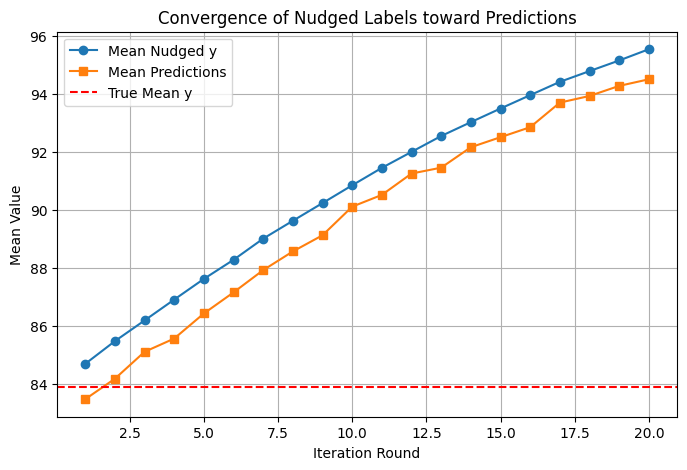

In [10]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")
plt.axhline(y=results['true_mean'].iloc[0], color='r', linestyle='--', label="True Mean y")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_ambiguity_simple(y, nudged_history, pred_history, var_history, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 1. Axis Settings
    ax.set_ylim(0, 105)
    n_samples = len(y)
    ax.set_xlim(0, n_samples)
    
    # 2. Sort Data by Initial VARIANCE (依照模糊度排序：左邊清楚 -> 右邊模糊)
    # 這樣顏色的深淺就會由左至右排列 (深 -> 淺)
    first_var = np.asarray(var_history[0])
    sort_idx = np.argsort(first_var)
    x_axis = np.arange(n_samples)
    
    y_init_sorted = np.asarray(y)[sort_idx]

    # 3. Static Elements
    ax.scatter(x_axis, y_init_sorted, color="grey", alpha=0.3, s=20, label="Original Score")
    
    # 4. Dynamic Elements
    scat_pred = ax.scatter([], [], color="blue", alpha=0.4, s=25, label="Prediction")
    
    # Nudged Score
    scat_score = ax.scatter([], [], c=[], cmap='RdYlGn', vmin=0, vmax=1.0, s=45, 
                            edgecolors='black', linewidth=0.2, label="Student Performance")
    
    # ==========================================
    # Text Position: Lower Left (左下角)
    # ==========================================
    # transform=ax.transAxes 使用相對座標 (0~1)
    # (0.02, 0.12) 代表靠左 2%，離底部 12% 的高度
    ax.text(0.02, 0.12, "Deep Green = High Clarity (Fast!)", # 改成綠色
            transform=ax.transAxes, color='forestgreen', fontweight='bold', fontsize=10)
            
    ax.text(0.02, 0.07, "Deep Red = High Ambiguity (Stuck)", # 改成紅色
            transform=ax.transAxes, color='firebrick', fontweight='bold', fontsize=10)
    
    ax.legend(loc='lower right', fontsize=9)
    # 更新 X 軸標籤說明
    ax.set_xlabel("Student Index (Sorted by Clarity: Clear -> Ambiguous)")
    ax.set_ylabel("Score")
    
    n_frames = min(len(pred_history), len(nudged_history) - 1)

    def update(frame):
        ax.set_title(f"Ambiguity Iteration {frame+1}")
        
        # Get data
        curr_y = np.asarray(nudged_history[frame+1])[sort_idx]
        curr_pred = np.asarray(pred_history[frame])[sort_idx]
        curr_var = np.asarray(var_history[frame])[sort_idx]
        
        # Logic: High Variance -> Low Speed -> Pale Color
        v_min, v_max = curr_var.min(), curr_var.max()
        if v_max - v_min > 0:
            var_norm = (curr_var - v_min) / (v_max - v_min)
        else:
            var_norm = np.zeros_like(curr_var)
        
        # 加上 Alpha 參數讓對比更強 (選擇性，這裡預設原本的邏輯)
        # 如果你覺得漸層不夠明顯，可以改成 np.exp(-var_norm * 3)
        speed_factor = np.exp(-var_norm*3) 
        
        # Update plots
        scat_pred.set_offsets(np.c_[x_axis, curr_pred])
        scat_score.set_offsets(np.c_[x_axis, curr_y])
        scat_score.set_array(speed_factor)
        
        return scat_pred, scat_score

    ani = animation.FuncAnimation(
        fig, update, frames=n_frames, interval=800, blit=False
    )

    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()

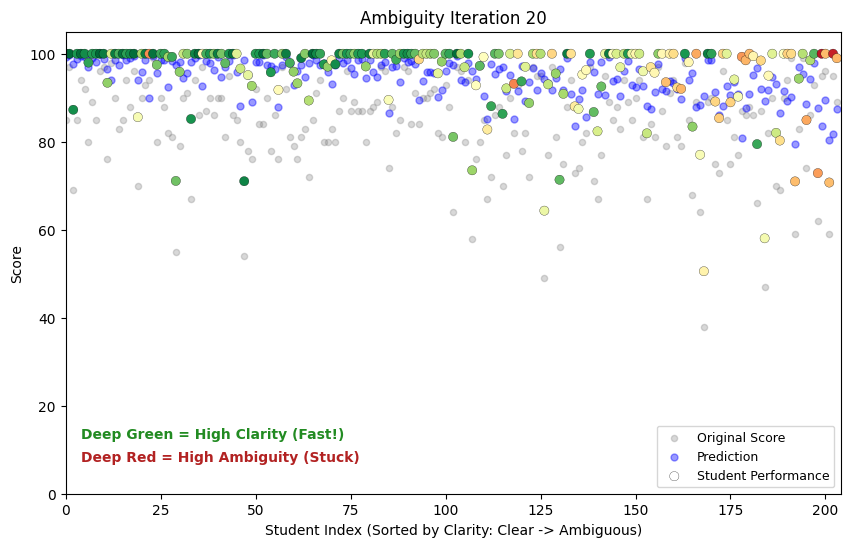

In [16]:
animate_ambiguity_simple(y, nudged_history, pred_history,var_history, save_path="ambiguity_animation.gif")

In [41]:
len(pred_history)

20

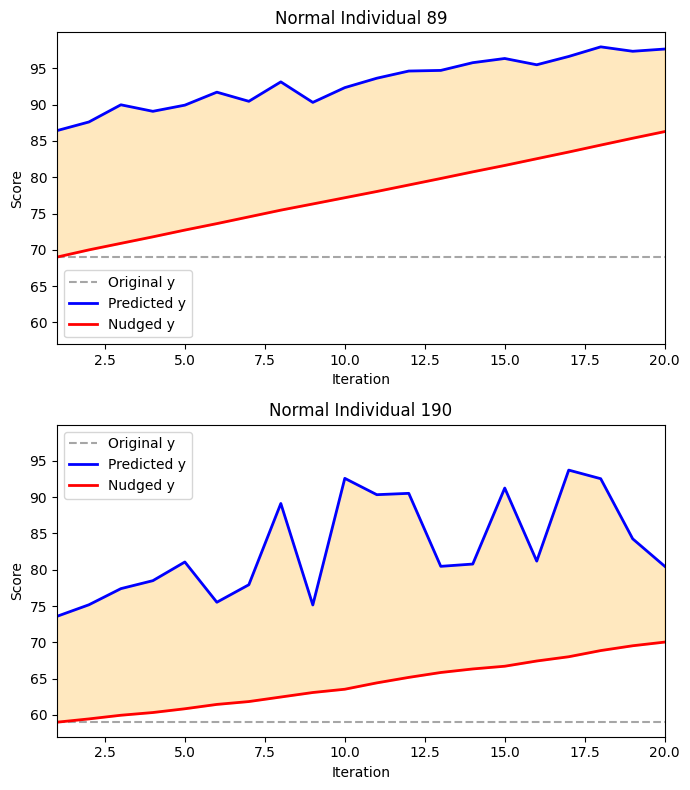

In [95]:
import matplotlib.pyplot as plt

selected_indices = [89, 190]    # selected individuals to observe
n_rounds = len(pred_history)
x_iter = range(1, n_rounds + 1)

# Set fixed y-axis range (min/max across all individuals)
all_preds = [pred_history[t] for t in range(n_rounds)]
all_nudged = [nudged_history[t] for t in range(n_rounds)]
y_min = min(min(p[i] for p in all_preds + all_nudged) for i in selected_indices)
y_max = max(max(p[i] for p in all_preds + all_nudged) for i in selected_indices)

fig, axes = plt.subplots(len(selected_indices), 1, figsize=(7, 4 * len(selected_indices)))

if len(selected_indices) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, idx in zip(axes, selected_indices):
    orig_score = [y[idx]] * n_rounds
    pred_scores = [pred_history[t][idx] for t in range(n_rounds)]
    nudged_scores = [nudged_history[t][idx] for t in range(n_rounds)]

    ax.plot(x_iter, orig_score, color='grey', linestyle='--', alpha=0.7, label='Original y')
    ax.plot(x_iter, pred_scores, color='blue', linewidth=2, label='Predicted y')
    ax.plot(x_iter, nudged_scores, color='red', linewidth=2, label='Nudged y')
    ax.fill_between(x_iter, pred_scores, nudged_scores, color='orange', alpha=0.25)

    ax.set_xlim(1, n_rounds)
    ax.set_ylim(y_min - 2, y_max + 2)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score")
    ax.set_title(f"Normal Individual {idx}")
    ax.legend(loc='best')
    ax.grid(False)

plt.tight_layout()
plt.show()


=== 動力分析 (排除天花板效應) ===

🚀 [動力最強/爬升最陡] (Lowest Variance):
  Student 135: 初始分 85.0 -> 最終分 100.0 | Variance: 31.1924 (極小)
  Student 146: 初始分 97.0 -> 最終分 100.0 | Variance: 32.8084 (極小)
  Student 89: 初始分 69.0 -> 最終分 87.3 | Variance: 32.9836 (極小)

🐢 [動力最弱/幾乎平躺] (Highest Variance):
  Student 188: 初始分 89.0 -> 最終分 99.0 | Variance: 335.6540 (極大)
  Student 199: 初始分 95.0 -> 最終分 100.0 | Variance: 318.1539 (極大)
  Student 190: 初始分 59.0 -> 最終分 70.7 | Variance: 272.2136 (極大)


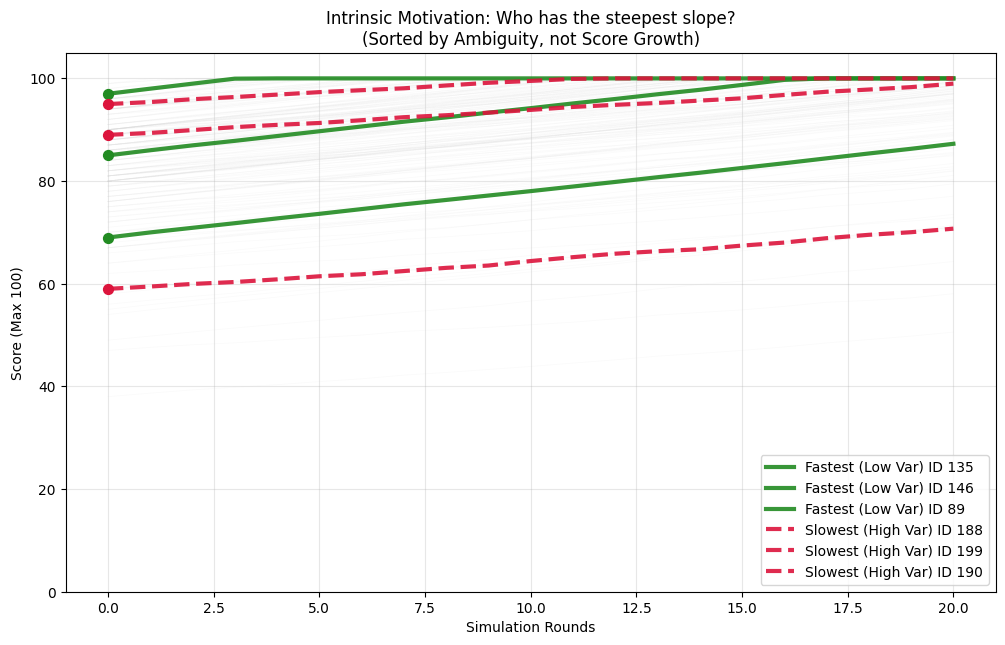

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_slopes_by_variance(y, nudged_history, var_history, top_n=3):
    """
    透過 Variance (內在動力) 來找出真正最快與最慢的學生，
    避免因為 "接近 100 分" (天花板效應) 而誤判。
    """
    # 1. 取得 "初始變異數" (這是決定速度的唯一因子)
    # 如果是 Fixed Variance 版本，取 var_history[0] 即可
    initial_variance = np.array(var_history[0])
    
    # 2. 排序 Index
    # argsort: 由小到大排列
    # 小 variance = 確定 = 快 (Fastest)
    # 大 variance = 模糊 = 慢 (Slowest)
    sorted_idx_by_var = np.argsort(initial_variance)
    
    fastest_indices = sorted_idx_by_var[:top_n]        # Variance 最小的前 N 名
    slowest_indices = sorted_idx_by_var[-top_n:]       # Variance 最大的後 N 名 (也就是列表最後面)
    
    history_matrix = np.array(nudged_history) # 轉成矩陣方便畫圖
    rounds = range(len(nudged_history))

    print(f"=== 動力分析 (排除天花板效應) ===")
    
    # 印出最快的 (Low Variance)
    print(f"\n🚀 [動力最強/爬升最陡] (Lowest Variance):")
    for idx in fastest_indices:
        init_score = y.iloc[idx]
        final_score = history_matrix[-1, idx]
        var_val = initial_variance[idx]
        print(f"  Student {idx}: 初始分 {init_score:.1f} -> 最終分 {final_score:.1f} | Variance: {var_val:.4f} (極小)")

    # 印出最慢的 (High Variance)
    print(f"\n🐢 [動力最弱/幾乎平躺] (Highest Variance):")
    for idx in reversed(slowest_indices): # 反轉一下，從最大的開始印
        init_score = y.iloc[idx]
        final_score = history_matrix[-1, idx]
        var_val = initial_variance[idx]
        print(f"  Student {idx}: 初始分 {init_score:.1f} -> 最終分 {final_score:.1f} | Variance: {var_val:.4f} (極大)")

    # 3. 畫圖：軌跡對比
    plt.figure(figsize=(12, 7))
    
    # 畫所有人的灰色背景 (淡淡的)
    for i in range(len(y)):
        plt.plot(rounds, history_matrix[:, i], color='lightgrey', alpha=0.1, linewidth=0.5)

    # 畫 "快" 的學生 (綠色)
    for i, idx in enumerate(fastest_indices):
        plt.plot(rounds, history_matrix[:, idx], 
                 color='forestgreen', linewidth=3, alpha=0.9, 
                 label=f'Fastest (Low Var) ID {idx}')
        # 標出起點
        plt.scatter(0, history_matrix[0, idx], color='forestgreen', s=50, zorder=5)
        
    # 畫 "慢" 的學生 (紅色)
    for i, idx in enumerate(reversed(slowest_indices)):
        plt.plot(rounds, history_matrix[:, idx], 
                 color='crimson', linewidth=3, linestyle='--', alpha=0.9, 
                 label=f'Slowest (High Var) ID {idx}')
        # 標出起點
        plt.scatter(0, history_matrix[0, idx], color='crimson', s=50, zorder=5)

    plt.title("Intrinsic Motivation: Who has the steepest slope?\n(Sorted by Ambiguity, not Score Growth)")
    plt.xlabel("Simulation Rounds")
    plt.ylabel("Score (Max 100)")
    plt.ylim(0, 105)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')
    plt.show()

# === 使用 ===
analyze_slopes_by_variance(y, nudged_history, var_history, top_n=3)